# Baseline: Central Clock Coordination

Agents move in a fixed order to ensure deterministic learning and reduce collisions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

In [2]:

# Environment parameters
GRID_SIZE = 5
NUM_AGENTS = 4
PICKUP_LOC = (0, 0)
DELIVERY_LOC = (4, 4)  # Known to agents

# Initialize Q-tables for each agent
q_tables = [defaultdict(lambda: np.zeros(4)) for _ in range(NUM_AGENTS)]


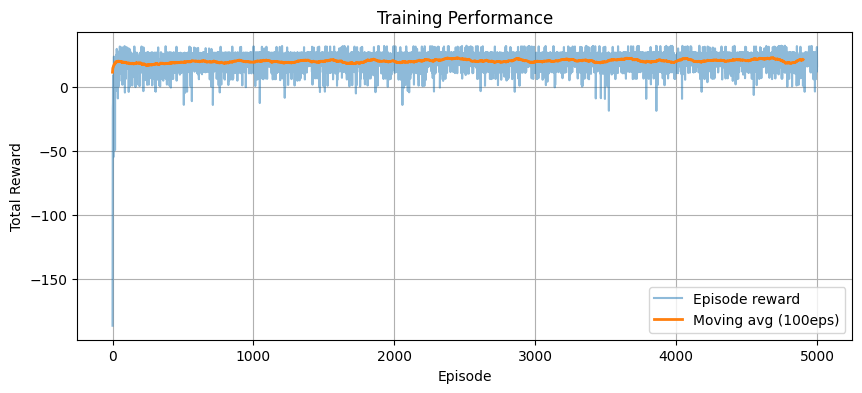

In [3]:

# Action space: 0=UP, 1=DOWN, 2=LEFT, 3=RIGHT
ACTIONS = [(0, -1), (0, 1), (-1, 0), (1, 0)]

def move(pos, action):
    dx, dy = ACTIONS[action]
    new_x = max(0, min(GRID_SIZE - 1, pos[0] + dx))
    new_y = max(0, min(GRID_SIZE - 1, pos[1] + dy))
    return (new_x, new_y)

def train(episodes=5000, alpha=0.1, gamma=0.9, epsilon=0.2):
    rewards_per_ep = []
    for ep in range(episodes):
        agent_positions = [PICKUP_LOC] * NUM_AGENTS
        carrying = [True] * NUM_AGENTS
        total_reward = 0
        steps = 0
        done = [False] * NUM_AGENTS
        while not all(done) and steps < 100:
            actions = []
            states = []
            for i in range(NUM_AGENTS):
                state = (agent_positions[i], carrying[i])
                states.append(state)
                if random.random() < epsilon:
                    action = random.randint(0, 3)
                else:
                    action = int(np.argmax(q_tables[i][state]))
                actions.append(action)
            # Central Clock order: agents act sequentially
            for i in range(NUM_AGENTS):
                if done[i]: continue
                old_pos = agent_positions[i]
                new_pos = move(old_pos, actions[i])
                reward = 0
                if carrying[i] and new_pos == DELIVERY_LOC:
                    reward = 10
                    carrying[i] = False
                    done[i] = True
                elif new_pos in agent_positions[:i]:  # simple collision check
                    reward = -5  # penalty for collision
                    new_pos = old_pos  # stay in place
                else:
                    reward = -0.1  # small step penalty
                agent_positions[i] = new_pos
                total_reward += reward
                new_state = (agent_positions[i], carrying[i])
                q_old = q_tables[i][states[i]][actions[i]]
                q_max_next = np.max(q_tables[i][new_state])
                q_tables[i][states[i]][actions[i]] += alpha * (reward + gamma * q_max_next - q_old)
            steps += 1
        rewards_per_ep.append(total_reward)
    return rewards_per_ep

# Run training and visualize
rewards = train()

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(rewards, alpha=0.5, label='Episode reward')
plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'), label='Moving avg (100eps)', linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance")
plt.legend()
plt.grid(True)
plt.show()


## Results
The graph above shows the learning performance of the agents.